In [3]:
from astropy.io import fits
file = fits.open('lightcurvesat2017gfo.fit')
print(file)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000137520BF0E0>, <astropy.io.fits.hdu.table.TableHDU object at 0x00000137520BF380>]


In [ ]:
data = file[1].data 

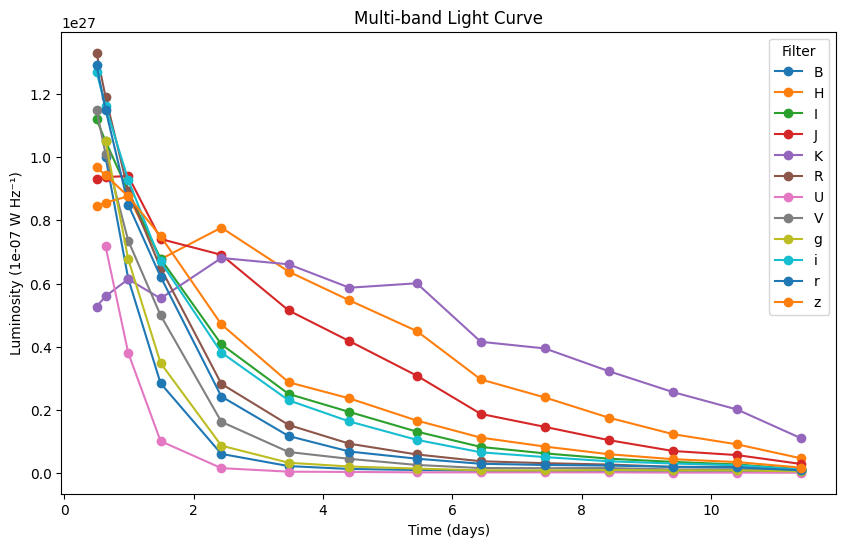

In [10]:
import matplotlib.pyplot as plt
import numpy as np

filters = np.unique(data['Filter']) #finds all unique filter values like 'U', 'B' 'R' etc.
plt.figure(figsize=(10, 6))

for f in filters:
    mask = data['Filter'] == f #creates a boolean array called mask that is true where the Filter matches the current filter and
                                #false where not
    time = data['Time'][mask].astype(float) #gets the time for values in that filter
    lum = data['Lum'][mask].astype(float) #gets the luminosity for values in that filter
    plt.plot(time, lum, marker='o', linestyle='-', label=f if hasattr(f, 'decode') else f) 

plt.xlabel('Time (days)')
plt.ylabel('Luminosity (1e-07 W Hz⁻¹)')
plt.title('Multi-band Light Curve')
plt.legend(title='Filter')
plt.show()


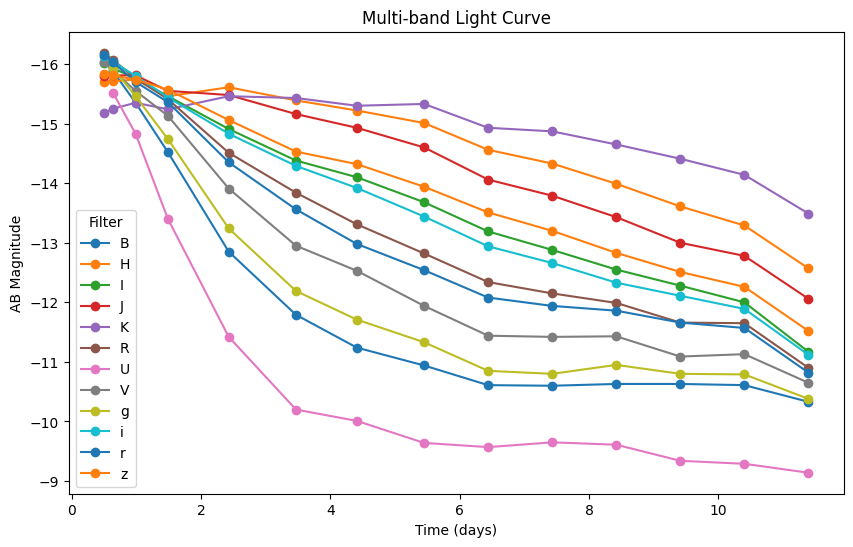

In [16]:
import matplotlib.pyplot as plt
import numpy as np

filters = np.unique(data['Filter']) #finds all unique filter values like 'U', 'B' 'R' etc.
plt.figure(figsize=(10, 6))

for f in filters:
    
    mask = data['Filter'] == f #creates a boolean array called mask that is true where the Filter matches the current filter and
                                #false where not
    time = data['Time'][mask].astype(float) #gets the time for values in that filter
    mag = data['Mag'][mask].astype(float)  #gets the ABSOLUTE magnitude for values in that filter
    plt.plot(time, mag, marker='o', linestyle='-', label=f if hasattr(f, 'decode') else f) 

plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('AB Magnitude')
plt.title('Multi-band Light Curve')
plt.legend(title='Filter')
plt.show()

C:\Users\WIT-Setup-20250108\AppData\Local\Temp\ipykernel_21580\72714147.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Filter')


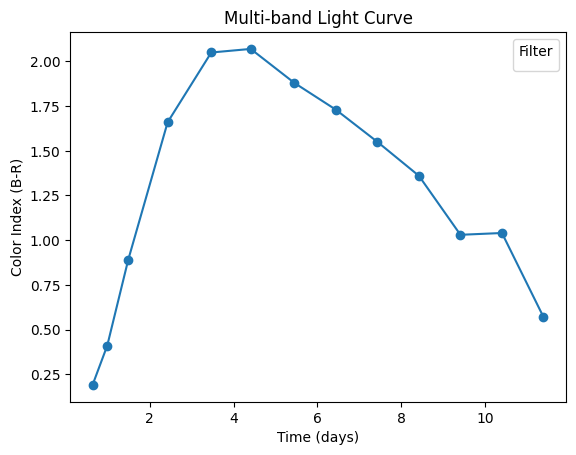

In [32]:
from scipy import interpolate
mag_r= []
time_r= []
mag_b = []
time_b = []
col_index = {}


for line in data:
    if line['Filter'] == 'B':
        mag_b.append(line['Mag'])
        time_b.append(line['Time'])
        
    if line['Filter'] == 'R':
        mag_r.append(line['Mag'])
        time_r.append(line['Time'])
mag_r.pop(0)
time_r.pop(0)
f = interpolate.interp1d(time_b, mag_b, fill_value='extrapolate')
# time_b.insert(0, np.float64(0.5))
# mag_b.insert(0, f(time_b[0]))
for i in range(len(mag_r)):
    col_index[(mag_b[i] - mag_r[i]).astype(float)] = ((time_b[i] + time_r[i])/2).astype(float)

plt.plot(col_index.values(), col_index.keys(),'-o') 

plt.xlabel('Time (days)')
plt.ylabel('Color Index (B-R)')
plt.title('Multi-band Light Curve')
plt.legend(title='Filter')
plt.show()